In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error,accuracy_score, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [4]:
df = pd.read_csv("../data/DSNY_Monthly_Tonnage_Data.csv")
# changing month to datetime for pandas
df['MONTH'] = pd.to_datetime(df['MONTH'])
df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24647 entries, 0 to 24646
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   MONTH                24647 non-null  datetime64[ns]
 1   BOROUGH              24647 non-null  object        
 2   COMMUNITYDISTRICT    24647 non-null  int64         
 3   REFUSETONSCOLLECTED  24647 non-null  float64       
 4   PAPERTONSCOLLECTED   22213 non-null  float64       
 5   MGPTONSCOLLECTED     22570 non-null  float64       
 6   RESORGANICSTONS      3095 non-null   float64       
 7   SCHOOLORGANICTONS    2308 non-null   float64       
 8   LEAVESORGANICTONS    881 non-null    object        
 9   XMASTREETONS         1685 non-null   float64       
 10  OTHERORGANICSTONS    1933 non-null   float64       
 11  BOROUGH_ID           24647 non-null  int64         
dtypes: datetime64[ns](1), float64(7), int64(2), object(2)
memory usage: 2.3+ MB


/var/folders/7n/rj4gbkk13_1f9n1qf54j12gh0000gp/T/ipykernel_48043/2461424894.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['MONTH'] = pd.to_datetime(df['MONTH'])


,MONTH,BOROUGH,COMMUNITYDISTRICT,REFUSETONSCOLLECTED,PAPERTONSCOLLECTED,MGPTONSCOLLECTED,RESORGANICSTONS,SCHOOLORGANICTONS,LEAVESORGANICTONS,XMASTREETONS,OTHERORGANICSTONS,BOROUGH_ID
0,2025-10-01,Bronx,1,3352.0,235.0,124.8,16.7,85.9,NaN,NaN,NaN,2
1,2025-10-01,Bronx,2,7942.4,231.6,213.8,20.4,100.7,NaN,NaN,NaN,2
2,2025-10-01,Bronx,3,2348.6,140.1,147.5,19.1,NaN,NaN,NaN,NaN,2
3,2025-10-01,Bronx,4,4210.4,233.3,291.1,20.8,70.7,NaN,NaN,0.3,2
4,2025-10-01,Bronx,5,3578.3,216.6,299.9,17.1,85.6,NaN,NaN,NaN,2


In [128]:
df.groupby('BOROUGH')['COMMUNITYDISTRICT'].unique()
# staten island has only 3 community districts (the least)
# manhattan and bronx have 12
# queens and brooklyn have 14+



BOROUGH
Bronx                      [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Brooklyn         [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
Manhattan                  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Queens             [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Staten Island                                            [1, 2, 3]
Name: COMMUNITYDISTRICT, dtype: object

<Axes: xlabel='PAPERTONSCOLLECTED', ylabel='REFUSETONSCOLLECTED'>

<Axes: xlabel='MGPTONSCOLLECTED', ylabel='REFUSETONSCOLLECTED'>

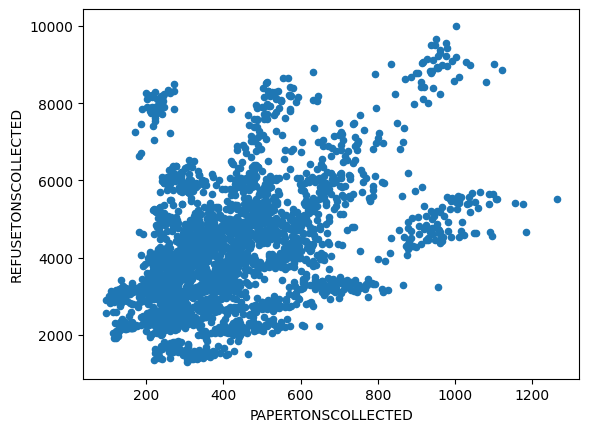

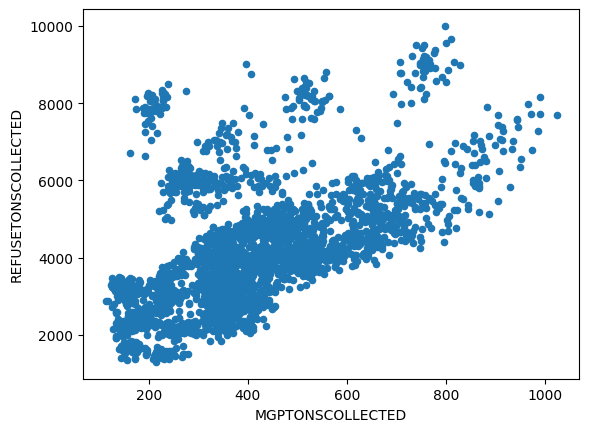

In [27]:
newdata = df[(df['MONTH'] >= '2022-01-01')]

# plots of both papers and mgptons are linear
display(newdata.plot(kind='scatter',x='PAPERTONSCOLLECTED',y='REFUSETONSCOLLECTED'))
display(newdata.plot(kind='scatter',x='MGPTONSCOLLECTED',y='REFUSETONSCOLLECTED'))

In [29]:
newdata["YEAR"]= newdata["MONTH"].dt.year
newdata.groupby(['YEAR','COMMUNITYDISTRICT']).agg({"REFUSETONSCOLLECTED":"sum"})

/var/folders/7n/rj4gbkk13_1f9n1qf54j12gh0000gp/T/ipykernel_48043/31618268.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdata["YEAR"]= newdata["MONTH"].dt.year


REFUSETONSCOLLECTED
YEAR COMMUNITYDISTRICT                     
2022 1                             247227.8
     2                             263537.3
     3                             281143.7
     4                             191301.1
     5                             176799.9
...                                     ...
2025 14                             82483.6
     15                             44210.4
     16                             29074.6
     17                             44155.7
     18                             51970.3

[72 rows x 1 columns]

In [47]:
newdata

,MONTH,BOROUGH,COMMUNITYDISTRICT,REFUSETONSCOLLECTED,PAPERTONSCOLLECTED,MGPTONSCOLLECTED,RESORGANICSTONS,SCHOOLORGANICTONS,LEAVESORGANICTONS,XMASTREETONS,OTHERORGANICSTONS,BOROUGH_ID,YEAR
0,2025-10-01,Bronx,1,3352.0,235.0,124.8,16.7,85.9,NaN,NaN,NaN,2,2025
1,2025-10-01,Bronx,2,7942.4,231.6,213.8,20.4,100.7,NaN,NaN,NaN,2,2025
2,2025-10-01,Bronx,3,2348.6,140.1,147.5,19.1,NaN,NaN,NaN,NaN,2,2025
3,2025-10-01,Bronx,4,4210.4,233.3,291.1,20.8,70.7,NaN,NaN,0.3,2,2025
4,2025-10-01,Bronx,5,3578.3,216.6,299.9,17.1,85.6,NaN,NaN,NaN,2,2025
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2709,2022-01-01,Queens,13,4239.9,423.9,747.9,NaN,NaN,NaN,10.0,NaN,4,2022
2710,2022-01-01,Queens,14,3135.0,265.7,227.2,NaN,NaN,NaN,13.5,NaN,4,2022
2711,2022-01-01,Staten Island,1,4958.5,675.0,644.6,NaN,NaN,NaN,21.7,NaN,5,2022
2712,2022-01-01,Staten Island,2,4538.3,510.0,501.8,NaN,16.4,18.1,14.3,4.8,5,2022


<Axes: xlabel='COMMUNITYDISTRICT,MONTH'>

<Axes: xlabel='COMMUNITYDISTRICT,YEAR'>

<Axes: xlabel='COMMUNITYDISTRICT,YEAR'>

<Axes: xlabel='COMMUNITYDISTRICT,YEAR'>

<Axes: xlabel='COMMUNITYDISTRICT,YEAR'>

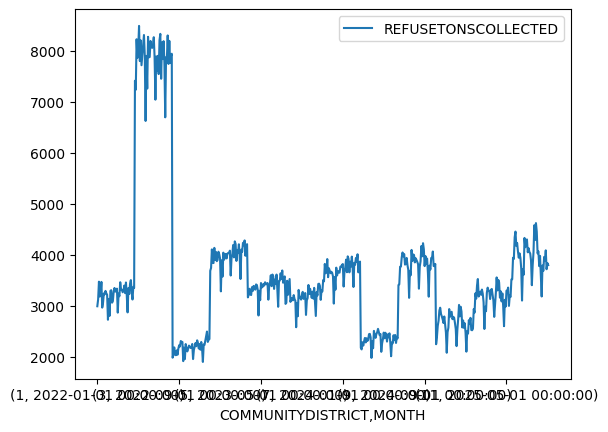

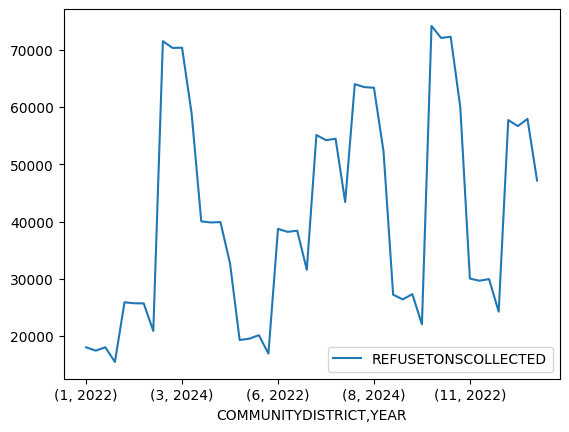

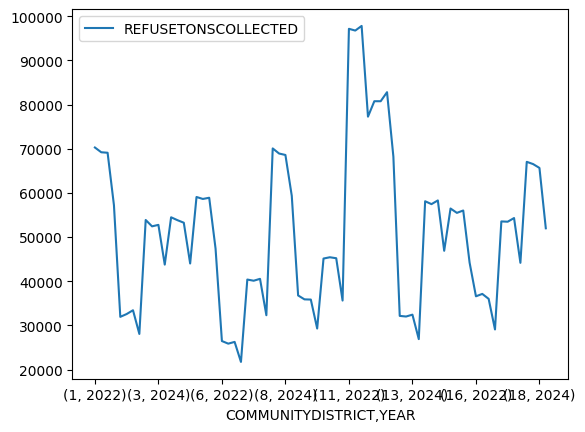

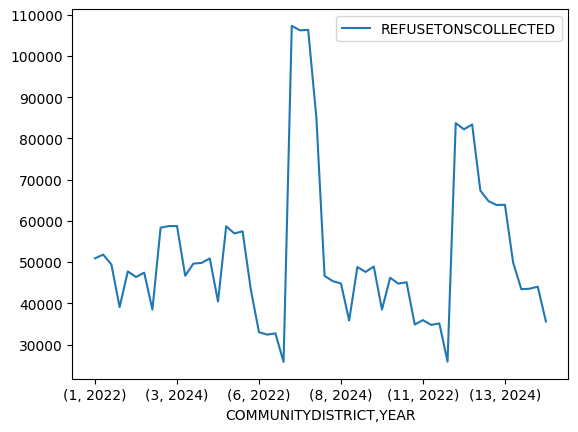

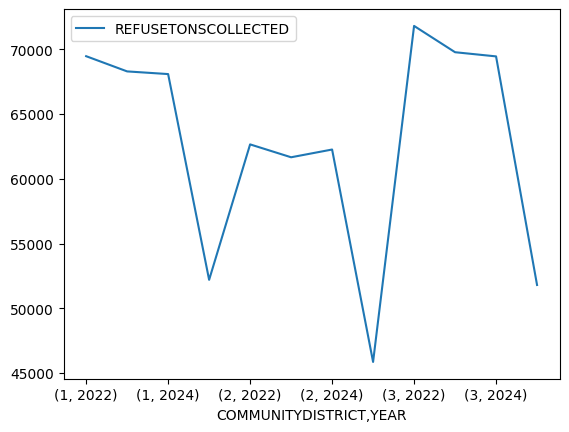

In [46]:
bronxdf = newdata[newdata["BOROUGH"] == "Bronx"]
manhattandf = newdata[newdata["BOROUGH"] == "Manhattan"]
brooklyndf = newdata[newdata["BOROUGH"] == "Brooklyn"]
queensdf = newdata[newdata["BOROUGH"] == "Queens"]
statenisland = newdata[newdata["BOROUGH"] == "Staten Island"]
#brooklyndf.groupby(['COMMUNITYDISTRICT','YEAR']).agg({"REFUSETONSCOLLECTED":"sum"}).plot(kind = 'line')
display(bronxdf.groupby(['COMMUNITYDISTRICT','MONTH']).agg({"REFUSETONSCOLLECTED":"sum"}).plot(kind = 'line'),
        manhattandf.groupby(['COMMUNITYDISTRICT','YEAR']).agg({"REFUSETONSCOLLECTED":"sum"}).plot(kind = 'line'),
        brooklyndf.groupby(['COMMUNITYDISTRICT','YEAR']).agg({"REFUSETONSCOLLECTED":"sum"}).plot(kind = 'line'),
        queensdf.groupby(['COMMUNITYDISTRICT','YEAR']).agg({"REFUSETONSCOLLECTED":"sum"}).plot(kind = 'line'),
        statenisland.groupby(['COMMUNITYDISTRICT','YEAR']).agg({"REFUSETONSCOLLECTED":"sum"}).plot(kind = 'line'))


/var/folders/3y/ldxff8k17wjcyzkq19xw1srm0000gn/T/ipykernel_51833/1465298311.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdata['paperxmgp'] = (newdata['PAPERTONSCOLLECTED'] * newdata['MGPTONSCOLLECTED'])


<Axes: xlabel='paperxmgp', ylabel='REFUSETONSCOLLECTED'>

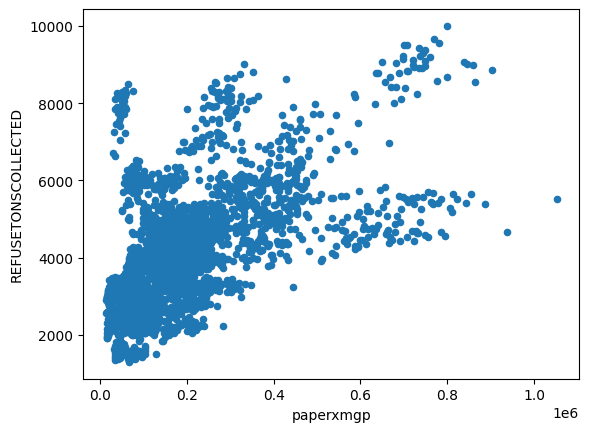

In [130]:
newdata['paperxmgp'] = (newdata['PAPERTONSCOLLECTED'] * newdata['MGPTONSCOLLECTED'])

# how else can we proportionately compare

newdata.plot(kind='scatter',x='paperxmgp',y='REFUSETONSCOLLECTED')

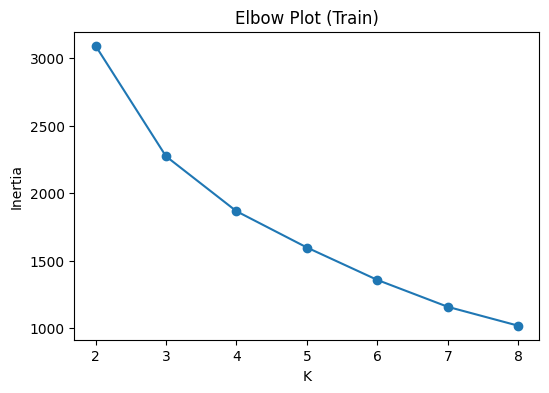

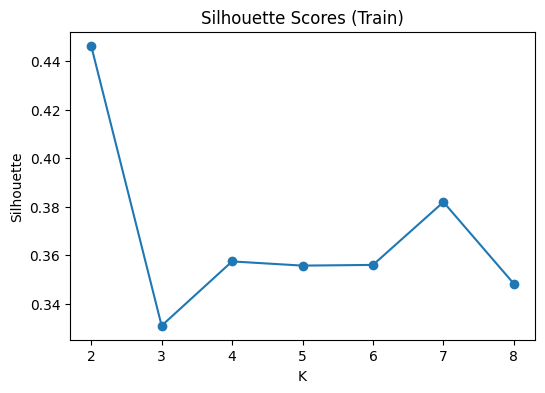

[3092.8540345018037, 2273.5208139583924, 1866.584735307862, 1597.6984757219818, 1357.3353772169255, 1158.1423733965466, 1018.1756792139989]
[0.44640158038493544, 0.33083022428882575, 0.35736709165062913, 0.3556417152044063, 0.3559291252153343, 0.38187770641730034, 0.348140996375476]


In [65]:
X = newdata[['PAPERTONSCOLLECTED','MGPTONSCOLLECTED','REFUSETONSCOLLECTED']]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

inertias = []
sil_scores = []

K_values = range(2, 9)

# For loop to go through K's
for K in K_values:
    kmeans = KMeans(n_clusters=K, random_state=42, n_init=10, max_iter=300)
    kmeans.fit(X_train_scaled)
    
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_train_scaled, kmeans.labels_))

plt.figure(figsize=(6,4))
plt.plot(K_values, inertias, marker='o')
plt.title("Elbow Plot (Train)")
plt.xlabel("K")
plt.ylabel("Inertia")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(K_values, sil_scores, marker='o')
plt.title("Silhouette Scores (Train)")
plt.xlabel("K")
plt.ylabel("Silhouette")
plt.show()

print(inertias)
print(sil_scores)


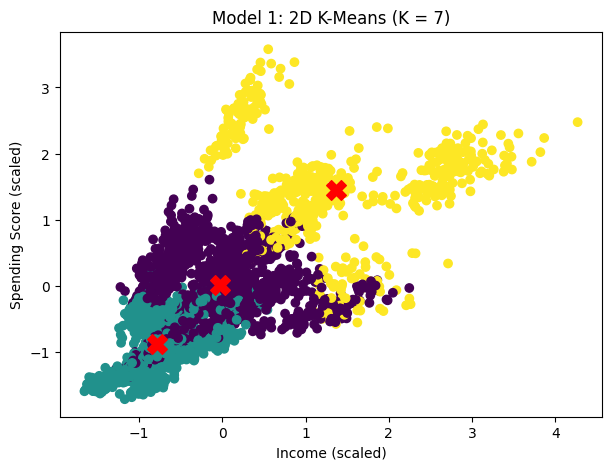

In [66]:
X2D = newdata[['PAPERTONSCOLLECTED','MGPTONSCOLLECTED','REFUSETONSCOLLECTED']]


# Scale each separately
Z2 = StandardScaler().fit_transform(X2D)


K_FIXED = 3

km2 = KMeans(n_clusters=K_FIXED, n_init=10, random_state=0).fit(Z2)
labels2 = km2.labels_
centers2 = km2.cluster_centers_


plt.figure(figsize=(7,5))
plt.scatter(Z2[:,0], Z2[:,1], c=labels2, cmap='viridis')
plt.scatter(centers2[:,0], centers2[:,1], c='red', s=200, marker='X')
plt.xlabel("Income (scaled)")
plt.ylabel("Spending Score (scaled)")
plt.title("Model 1: 2D K-Means (K = 7)")
plt.show()

In [131]:
# building a pipeline

# checking if bmi and sex contribute to disease progression
num_features = ['PAPERTONSCOLLECTED','MGPTONSCOLLECTED','paperxmgp']
# also checking if age contributes

num_pipe = Pipeline([
    ("scale", StandardScaler())
])

preprocess = ColumnTransformer([
    ("num", num_pipe, num_features),
])

model = Pipeline([
    ("prep", preprocess),
    ("reg", LinearRegression())
])


In [146]:
# simple model

X = newdata[['PAPERTONSCOLLECTED','MGPTONSCOLLECTED','paperxmgp']]
y = newdata['REFUSETONSCOLLECTED']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=16)

model.fit(X_train,y_train)

# --- Evaluate the model on the unseen testing data ---
predictions = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
papercoefficient = model.named_steps['reg'].coef_[0]
mgpcoefficient = model.named_steps['reg'].coef_[1]
paperxmgpcoefficient = model.named_steps['reg'].coef_[2]


print(f"Root Mean Squared Error (RMSE) on Test Data: {rmse:.2f}")
print(f"R Squared: {r2:.2f}")
print(f"Coefficients: {papercoefficient, mgpcoefficient, paperxmgpcoefficient}")

print(f"\nInterpretation: Our model's predictions on new data are off by an average of {rmse:,.2f}.")


predictions.mean()

Root Mean Squared Error (RMSE) on Test Data: 1307.25
R Squared: 0.32
Coefficients: (np.float64(-55.257833917074976), np.float64(503.4874132880162), np.float64(478.594176507915))

Interpretation: Our model's predictions on new data are off by an average of 1,307.25.


np.float64(4142.1506545712155)